## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명 : 머신러닝알고리즘 이해 및 활용
- 평가일 : 03.10
- 성명 : 권혁종
- 점수 : 70

Q1. iris data를 불러와서 아래 사항을 수행하세요.(15점)

- 결정트리 모델을 시각화하고 주요한 인사이트를 기술하세요.(tree.plot_tree or tree.export_graphviz 이용)
- Feature importance를 추출하고 시각화하세요. 10

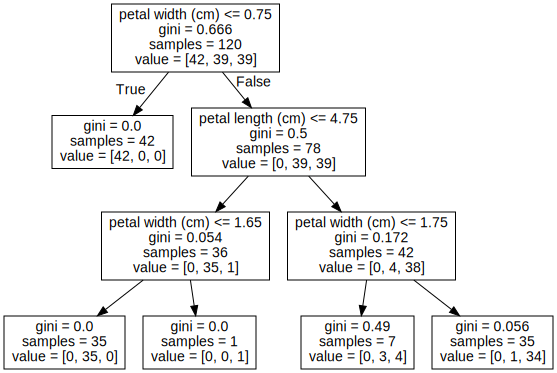

In [14]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import graphviz

dataset = load_iris()
df_iris = pd.DataFrame(data=dataset.data,columns = dataset.feature_names)
y = dataset.target

dt_clf = DecisionTreeClassifier(random_state =132,max_depth=3)
X_train,X_test,y_train,y_test = train_test_split(df_iris,y,test_size = 0.2,random_state=135)
dt_clf.fit(X_train,y_train)

data = tree.export_graphviz(decision_tree=dt_clf,
                            feature_names=dataset.feature_names)
graphviz.Source(data)

# petal의 너비와 길이로 3개의 품종이 대부분 가려진다.

[0.        0.        0.3998127 0.6001873]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


<AxesSubplot:>

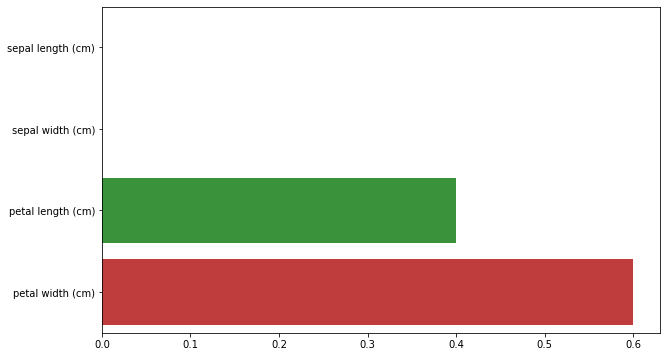

In [15]:
import seaborn as sns
print(dt_clf.feature_importances_)
print(dataset.feature_names)

plt.figure(figsize=(10,6))
sns.barplot(dt_clf.feature_importances_,dataset.feature_names)


Q2~Q3. 'dataset/creditcard.csv'를 불러와서 신용카드 사기 검출 분류문제를 아래와 같이 수행하세요(10점) 10
- 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
    - 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
    - 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
    - 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
    
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [16]:
df = pd.read_csv('../../bigdatafile/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
def timedrop(df):
    df1 = df.drop('Time',axis=1)
    return df1
def datasplit(df):
    df = timedrop(df)
    X = df.drop('Class',axis=1)
    y = df['Class']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 123)
    return X_train,X_test,y_train,y_test
def scores(y_test,pred=None,pred_proba=None):
    con = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc = roc_auc_score(y_test,pred_proba)
    print(f'혼동행렬 : \n {con} \n정확도 : {acc:0.4f}, 정밀도 : {pre:0.4f}, 재현율 : {rec:0.4f}, f1_score : {f1:0.4f}, roc_auc : {roc:0.4f}')

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
X_train,X_test,y_train,y_test = datasplit(df)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)[:,1]
scores(y_test,pred,pred_proba)

혼동행렬 : 
 [[85262    21]
 [   59   101]] 
정확도 : 0.9991, 정밀도 : 0.8279, 재현율 : 0.6312, f1_score : 0.7163, roc_auc : 0.9794


- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [21]:
from lightgbm import LGBMClassifier
def lgbm_score(Estimator,X_train,X_test,y_train,y_test):
    lgbm = Estimator(n_estimators=1000,num_leaves=64,boost_from_average=False)
    lgbm.fit(X_train,y_train,early_stopping_rounds=100,eval_set=[(X_test,y_test)],eval_metric='logloss')
    pred = lgbm.predict(X_test)
    pred_proba = lgbm.predict_proba(X_test)[:,1]
    scores(y_test,pred,pred_proba)
def lr_score(X_train,X_test,y_train,y_test):
    lr = LogisticRegression()
    lr.fit(X_train,y_train)
    pred = lr.predict(X_test)
    pred_proba = lr.predict_proba(X_test)[:,1]
    scores(y_test,pred,pred_proba)

In [22]:
lgbm_score(LGBMClassifier,X_train,X_test,y_train,y_test)

[1]	valid_0's binary_logloss: 0.598338
[2]	valid_0's binary_logloss: 0.520691
[3]	valid_0's binary_logloss: 0.455945
[4]	valid_0's binary_logloss: 0.401208
[5]	valid_0's binary_logloss: 0.354459
[6]	valid_0's binary_logloss: 0.314194
[7]	valid_0's binary_logloss: 0.279262
[8]	valid_0's binary_logloss: 0.248795
[9]	valid_0's binary_logloss: 0.222103
[10]	valid_0's binary_logloss: 0.198622
[11]	valid_0's binary_logloss: 0.177893
[12]	valid_0's binary_logloss: 0.159544
[13]	valid_0's binary_logloss: 0.143267
[14]	valid_0's binary_logloss: 0.128787
[15]	valid_0's binary_logloss: 0.11588
[16]	valid_0's binary_logloss: 0.10436
[17]	valid_0's binary_logloss: 0.0940656
[18]	valid_0's binary_logloss: 0.0848588
[19]	valid_0's binary_logloss: 0.0766139
[20]	valid_0's binary_logloss: 0.0692152
[21]	valid_0's binary_logloss: 0.0625759
[22]	valid_0's binary_logloss: 0.0566073
[23]	valid_0's binary_logloss: 0.051248
[24]	valid_0's binary_logloss: 0.0464302
[25]	valid_0's binary_logloss: 0.0420921
[26

 - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

In [23]:
import numpy as np
def log_amount(df):
    df['Amount'] = np.log1p(df['Amount'])
    return df
df = log_amount(df)
X_train,X_test,y_train,y_test = datasplit(df)
lr_score(X_train,X_test,y_train,y_test)

혼동행렬 : 
 [[85266    17]
 [   64    96]] 
정확도 : 0.9991, 정밀도 : 0.8496, 재현율 : 0.6000, f1_score : 0.7033, roc_auc : 0.9774


In [24]:
lgbm_score(LGBMClassifier,X_train,X_test,y_train,y_test)

[1]	valid_0's binary_logloss: 0.598338
[2]	valid_0's binary_logloss: 0.520691
[3]	valid_0's binary_logloss: 0.455945
[4]	valid_0's binary_logloss: 0.401208
[5]	valid_0's binary_logloss: 0.354459
[6]	valid_0's binary_logloss: 0.314194
[7]	valid_0's binary_logloss: 0.279262
[8]	valid_0's binary_logloss: 0.248795
[9]	valid_0's binary_logloss: 0.222103
[10]	valid_0's binary_logloss: 0.198622
[11]	valid_0's binary_logloss: 0.177893
[12]	valid_0's binary_logloss: 0.159544
[13]	valid_0's binary_logloss: 0.143267
[14]	valid_0's binary_logloss: 0.128787
[15]	valid_0's binary_logloss: 0.11588
[16]	valid_0's binary_logloss: 0.10436
[17]	valid_0's binary_logloss: 0.0940656
[18]	valid_0's binary_logloss: 0.0848588
[19]	valid_0's binary_logloss: 0.0766139
[20]	valid_0's binary_logloss: 0.0692152
[21]	valid_0's binary_logloss: 0.0625759
[22]	valid_0's binary_logloss: 0.0566073
[23]	valid_0's binary_logloss: 0.051248
[24]	valid_0's binary_logloss: 0.0464302
[25]	valid_0's binary_logloss: 0.0420921
[26

Q4. Q2 신용카드 사기 검출 분류문제에서 아래를 참고하여 이상치 데이터를 제거하고 모델 학습/예측/평가를 수행하세요(5점)2.5
- 히트맵을 이용해 레이블과의 상관성을 시각화 
- 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
- 사용자 함수를 이용하여 이상치 검출
- 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

<AxesSubplot:>

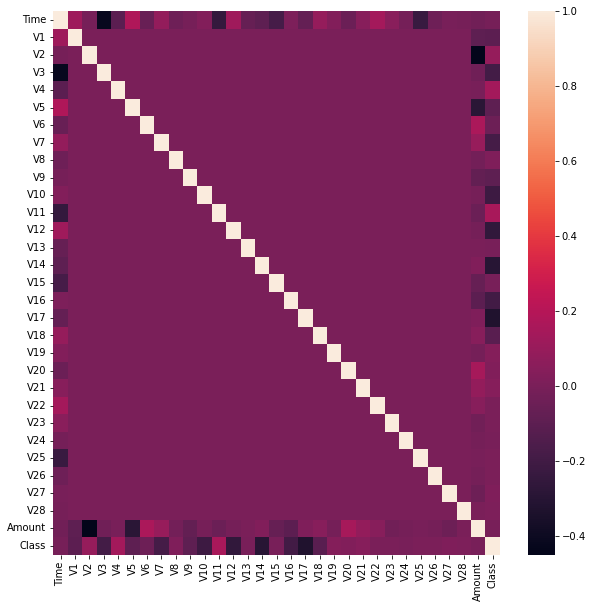

In [25]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr())

Q5. SMOTE 오버 샘플링 적용 후 LightGBM 모델을 이용하여 학습, 예측, 평가를 수행하세요.(10점)0

Q6. 사이킷런에서 제공해주는 load_boston 데이터셋을 가져와서 아래 사항을 수행하세요.(10점)7.5
- 데이터셋의 타겟 이름을 'PRICE'로 지정한 후 데이터프레임을 생성 pickle 파일로 저장 후 다시 불어오세요.
- 히트맵을 이용하여 타겟과 상관관계가 높은 독립 변수를 선택하세요.
- 종속변수를 로그 변환하세요
- 위의 사항을 반영하여 선회회귀 모델을 생성 후 평가하고 회귀계수를 출력하세요.

In [26]:
def score_r(y_test,y_pred):
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,pred)
    print(f'mse : {mse}, rmse : {rmse}, r2_score = {r2}')

In [27]:
from sklearn.datasets import load_boston
data = load_boston()
dt_boston = pd.DataFrame(data=data.data,columns=data.feature_names)
dt_boston['PRICE'] = data.target
dt_boston.to_pickle('df_boston.pkl')
dt_boston = pd.read_pickle('df_boston.pkl')

In [28]:
corr = abs(dt_boston.corr()['PRICE']).sort_values()
corr
# LSTAT이 가장 상관관계가 높음
corr_list = ['LSTAT','RM','PTRATIO','INDUS','TAX','NOX','CRIM','RAD']

In [29]:
for i in corr_list:
    dt_boston[i] = np.log1p(dt_boston[i])

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
lr = LinearRegression()
X = dt_boston.drop('PRICE',axis =1)
y = dt_boston['PRICE']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 123)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
score_r(y_test,pred)
lr.coef_

mse : 22.90005366375451, rmse : 4.785400052634524, r2_score = 0.7166819952083142


array([-7.83578619e-01,  1.29761670e-02, -1.49893583e-01,  8.11800078e-01,
       -1.82092594e+01,  2.04147942e+01,  2.74593936e-02, -1.17203777e+00,
        2.66279721e+00, -3.65209147e+00, -1.63408906e+01,  3.65588222e-03,
       -1.06672191e+01])

Q7. house_df.pkl 데이터셋을 불러와서 아래사항을 수행하세요.(15점) 10
- alphas = [0, 0.1, 1, 10, 100] 를 적용하여 Ridge 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력 
- lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력(def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
- elastic_alphas = [0.07,0.1,0.5,1,3] 를 적용, ElasticNet 회귀 모델링 및 교차검증 후 5 폴드 평균 RMSE를 출력(사용자 함수 이용)

In [31]:
house_df = pd.read_pickle('./dataset/house_df.pkl')
house_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [32]:
X = house_df.drop('PRICE',axis=1)
y = house_df['PRICE']

In [33]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import cross_val_score
alphas = [0, 0.1, 1, 10, 100]
lasso_alphas = [0.07,0.1,0.5,1,3]
elastic_alphas = [0.07,0.1,0.5,1,3]
rmse_list = []
for i in alphas:
    ridge = Ridge(alpha=i)
    score = cross_val_score(ridge,X,y,scoring='neg_mean_squared_error',cv=5)
    rmse_list.append(np.sqrt(-1*score.mean()))
    print('alpha : ', i)
    print(np.mean(rmse_list))

alpha :  0
6.093587405436876
alpha :  0.1
6.0761106775700435
alpha :  1
6.030267081364914
alpha :  10
5.967415344755178
alpha :  100
5.8676543967752846


In [37]:
# lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력
# (def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True):
    rmse_list = []
    for i in params:
        clf = model_name(alpha = i)
        score = cross_val_score(clf,X_data_n,y_target_n,scoring='neg_mean_squared_error',cv=5,verbose = verbose)
        rmse_list.append(np.sqrt(-1*score.mean()))
        print('alpha : ', i)
        print(np.mean(rmse_list))
get_linear_reg_eval(Lasso,lasso_alphas,X,y)

alpha :  0.07
5.907231325847088
alpha :  0.1
5.9044813121103505
alpha :  0.5
5.898013011177185
alpha :  1
5.913719060391647
alpha :  3
6.0055156363797835


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [38]:
get_linear_reg_eval(ElasticNet,elastic_alphas,X,y)

alpha :  0.07
5.746594668577731
alpha :  0.1
5.724713027648879
alpha :  0.5
5.667484785929898
alpha :  1
5.666013042042827
alpha :  3
5.757869445644106


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Q8. load_boston 데이터셋을 불러와서 다음사항을 수행하세요.0
- SVM 알고리즘을 활용한 주택가격 예측모델 생성 및 평가(MSE, RMSE, R2)
- 개발된 예측모델을 활용하여 아래 test_data가 주어졌은때의 주택가격 예측<br>
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]

Q9. mtcars 데이터셋(mtcars.csv)의 qsec 컬럼을 최소최대 척도(Min-Max Scale)로 변환한 후 0.5보다 
큰 값을 가지는 레코드 수를 구하시오 10

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mtcars = pd.read_csv('./dataset/mtcars.csv')
mtcars['qsec'] = scaler.fit_transform(mtcars[['qsec']])
mtcars.loc[mtcars.qsec>0.5].count()
# 9개

Unnamed: 0    9
mpg           9
cyl           9
disp          9
hp            9
drat          9
wt            9
qsec          9
vs            9
am            9
gear          9
carb          9
dtype: int64

Q10. purdata.csv는 백화점 고객의 1년 간 구매 데이터이다. 아래사항을 수행하세요.10
 
- 남성고객을 분류하는 모델을 생성(분류알고리즘 : dt,rf,lr)
- 모델 성능을 roc_auc로 평가 

In [23]:
purdata = pd.read_csv('./dataset/purdata.csv')
purdata.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,1,*,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,3,*,4935000,NaN,기타,광주점,18,2.444444,0.318182,16,1
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0


In [24]:
def get_catmax(X,c1,c2,c3):
    cat = ''                #여기에 저장됨
    if X < c1 : cat = 1
    elif X < c2: cat = 2
    elif X < c3: cat = 3
    else:
        cat = 4
    return cat
def get_cat(df,column):
    c = df[column]
    c1 = np.percentile(c,25)
    c2 = np.percentile(c,50)
    c3 = np.percentile(c,75)
    df[column] = df[column].apply(lambda X : get_catmax(X,c1,c2,c3))

In [25]:
purdata['총구매액'].replace('*',np.nan ,inplace=True)
purdata.dropna(subset='총구매액',inplace=True)
purdata.drop('cust_id',axis=1,inplace=True)
purdata.총구매액.astype(float)

0        68282840.0
2         3197000.0
4        29050000.0
5        11379000.0
6        10056000.0
           ...     
3495      3175200.0
3496     29628600.0
3497        75000.0
3498      1875000.0
3499    263101550.0
Name: 총구매액, Length: 3498, dtype: float64

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
purdata['주구매상품'] = le.fit_transform(purdata['주구매상품'])
purdata['주구매지점'] = le.fit_transform(purdata['주구매지점'])

purdata.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,68282840,11264000,6860000.0,5,0,19,3.894737,0.527027,17,0
2,3197000,1639000,NaN,6,1,2,2.000000,0.000000,1,1
4,29050000,24000000,NaN,15,8,2,1.500000,0.000000,85,0
5,11379000,9552000,462000.0,11,18,3,1.666667,0.200000,42,0
6,10056000,7612000,4582000.0,22,0,5,2.400000,0.333333,42,0


In [52]:
purdata.환불금액.fillna(0,inplace = True)
purdata['환불금액'] = np.where(purdata.환불금액 == 0 ,0,1)

In [56]:
get_cat(purdata,'최대구매액')

In [65]:
def modelscores(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:,1]
    con = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc = roc_auc_score(y_test,pred_proba)
    print(f'모델 : {model} \n혼동행렬 : \n {con} \n정확도 : {acc:0.4f}, 정밀도 : {pre:0.4f}, 재현율 : {rec:0.4f}, f1_score : {f1:0.4f}, roc_auc : {roc:0.4f}\n')

In [66]:
from sklearn.ensemble import RandomForestClassifier
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
X_train,X_test,y_train,y_test = train_test_split(purdata.drop('gender',axis=1),purdata['gender'],test_size=0.2,random_state=123)
modelscores(dt,X_train,X_test,y_train,y_test)
modelscores(rf,X_train,X_test,y_train,y_test)
modelscores(lr,X_train,X_test,y_train,y_test)

모델 : DecisionTreeClassifier() 
혼동행렬 : 
 [[266 170]
 [150 114]] 
정확도 : 0.5429, 정밀도 : 0.4014, 재현율 : 0.4318, f1_score : 0.4161, roc_auc : 0.5210

모델 : RandomForestClassifier() 
혼동행렬 : 
 [[340  96]
 [167  97]] 
정확도 : 0.6243, 정밀도 : 0.5026, 재현율 : 0.3674, f1_score : 0.4245, roc_auc : 0.6168

모델 : LogisticRegression() 
혼동행렬 : 
 [[435   1]
 [264   0]] 
정확도 : 0.6214, 정밀도 : 0.0000, 재현율 : 0.0000, f1_score : 0.0000, roc_auc : 0.6191

